<a href="https://colab.research.google.com/github/MateoMu/TDS_III/blob/master/Mini_Proyecto1_MateoMu%C3%B1ozArroyave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

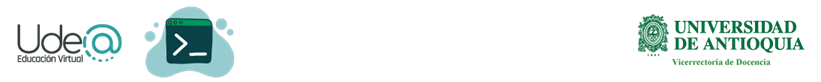


**Tratamiento de Señales III** *Mini-Proyecto 1*

**Adquisicion de datos y aplicación de técnicas de preprocesamiento para resolver un problema particular**

*Analisis de Bio-señales para Computación Afectiva*

*   Mateo Muñoz Arroyave
    CC 1036676919


**Autor:**
*   Hernán Felipe García Arias, PhD.



**Facultad de Ingeniería**

**Universidad de Antioquia**

---

##Importación de librerias

In [ ]:
import scipy.io as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import argrelextrema
import pandas as pd
from scipy.signal import butter, lfilter, filtfilt, sosfilt

In [ ]:
# Descargamos el archivo Emocional

#https://drive.google.com/file/d/1cNMil1P60z-XrqExnnKvmggmXWhI3glZ/view?usp=drive_link
#https://drive.google.com/file/d/1Fu3HL-cB64lTfuZS8iPhIfaJIsl1OszD/view?usp=drive_link
#https://drive.google.com/file/d/1cBN0CYdrsUsVO77PyNq-Jkyh5pc0FI22/view?usp=drive_link
#https://drive.google.com/file/d/1bMObQcIFrNalRmD1LaNuqVSTeqaeGqR3/view?usp=drive_link

!gdown '1cNMil1P60z-XrqExnnKvmggmXWhI3glZ'
!gdown '1Fu3HL-cB64lTfuZS8iPhIfaJIsl1OszD'
!gdown '1cBN0CYdrsUsVO77PyNq-Jkyh5pc0FI22'
!gdown '1bMObQcIFrNalRmD1LaNuqVSTeqaeGqR3'

Downloading...
From: https://drive.google.com/uc?id=1cNMil1P60z-XrqExnnKvmggmXWhI3glZ
To: /content/s14.mat
100% 80.6M/80.6M [00:00<00:00, 200MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Fu3HL-cB64lTfuZS8iPhIfaJIsl1OszD
To: /content/s15.mat
100% 80.7M/80.7M [00:00<00:00, 179MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cBN0CYdrsUsVO77PyNq-Jkyh5pc0FI22
To: /content/s16.mat
100% 80.8M/80.8M [00:00<00:00, 189MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bMObQcIFrNalRmD1LaNuqVSTeqaeGqR3
To: /content/s17.mat
100% 80.7M/80.7M [00:00<00:00, 171MB/s]


###Se cargan todos los datos de los paciente

In [ ]:
datosP1 = sc.loadmat('s14.mat')
datosP2 = sc.loadmat('s15.mat')
datosP3 = sc.loadmat('s16.mat')
datosP4 = sc.loadmat('s17.mat')

signals = datosP1['data']
signalsP2 = datosP2['data']
signalsP3 = datosP3['data']
signalsP4 = datosP4['data']

etiquetas = datosP1['labels']
etiquetasP2 = datosP2['labels']
etiquetasP3 = datosP3['labels']
etiquetasP4 = datosP4['labels']
# Esto me arrojará un nd array de n_video * id_signal * Ntimepoints

In [ ]:
def normalize_min_max(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data


##Caracteristicas del GSR (RESISTENCIA GALVANICA DE LA PIEL)

- Minimos locales
- 10 potencias espectrales en la banda de [0-2.4] Hz
- Tiempo medio de subida

###Minimos locales GSR

In [ ]:

# Itera sobre cada conjunto de datos y encuentra los mínimos locales
def mini_local(GSR):
  datos_normalizados_GSR = normalize_min_max(GSR)
  minimos_locales = argrelextrema(datos_normalizados_GSR, np.less)[0]
  minimos_locales = len(minimos_locales)

  return minimos_locales

###10 potencias espectrales en las bandas 0-2.4Hz

In [ ]:
def Pot_Freq(GSR):

  # Definir los parámetros del filtro pasa banda (0.0-2.4 Hz)
  frec_corte_baja = 0.01
  frec_corte_alta = 2.4
  nyq = 0.5 * Fs
  frec_baja = frec_corte_baja / nyq
  frec_alta = frec_corte_alta / nyq

  # Diseñar el filtro pasa banda
  sos = butter(N=4, Wn=[frec_baja, frec_alta], btype='bandpass', output = 'sos')

  # Aplicar el filtro pasa banda a la señal de GSR
  GSR_filtrada = sosfilt(sos, GSR) # Inicializar la matriz filtrada

  # Calcular la FFT de la señal filtrada
  fft_resultado = np.fft.fft(GSR_filtrada)
  fft_resultado_positivo = fft_resultado[:len(fft_resultado)//2]
  frecuencias = np.fft.fftfreq(len(fft_resultado_positivo), d=Fs/len(fft_resultado_positivo))

  # Calcula las potencias espectrales en la banda de 0 a 2.4 Hz
  potencias_banda = np.abs(fft_resultado_positivo)**2

  # Toma las 10 primeras potencias
  indices_top_10_potencias = np.argsort(potencias_banda)[::-1][:10]
  top_10_potencias = potencias_banda[indices_top_10_potencias]
  frecuencias_top_10 = frecuencias[indices_top_10_potencias]

  return top_10_potencias,frecuencias_top_10
#Pot_Freq(GSR)

### Tiempo medio de subida

In [ ]:
def Tiempo_medio(GSR):
  # Definir el porcentaje de subida (por ejemplo, del 10% al 90%)
  porcentaje_inicial = 10
  porcentaje_final = 90

  # Calcular los valores correspondientes a los percentiles
  valor_inicial = np.percentile(GSR, porcentaje_inicial)
  valor_final = np.percentile(GSR, porcentaje_final)

  # Encontrar los índices donde la señal cruza esos valores
  indices_inicial = np.where(GSR >= valor_inicial)[0]
  indices_final = np.where(GSR >= valor_final)[0]

  # Encontrar el tiempo medio de subida para cada transición
  min_len = min(len(indices_inicial), len(indices_final))
  tiempos_subida = []

  for i in range(min_len):
      tiempo_subida = (indices_final[i] - indices_inicial[i]) / Fs
      tiempos_subida.append(tiempo_subida)

  # Calcular el tiempo medio de subida
  tiempo_medio_subida = np.mean(tiempos_subida)

  # Imprimir el tiempo medio de subida
  # print('Tiempo medio de subida:', tiempo_medio_subida, 'segundos')
  # print('Tiempo medio de subida:', len(tiempos_subida), 'segundos')

  return tiempo_medio_subida

###Funcion par agrupar los datos de todas las caracteristicas

In [ ]:
def data_GSR(signals):
  GSR = signals[:,33,:]
  datos_normalizados_GSR = normalize_min_max(GSR)

  #Ciclo donde agrega al vector todos_GSR las caracteristicas de los datos GSR
  todos_GSR = []
  for i in range(log):
    GSR = signals[i,33,:]
    todos_GSR.append(mini_local(GSR))
    todos_GSR.append(Pot_Freq(GSR))
    todos_GSR.append(Tiempo_medio(GSR))

  #Crea un nuevo vector para ordenar todos sus datos
  xGSR = []

  # Recorre los elementos del vector original y agrega los valores a nuevo_vector
  for elemento in todos_GSR:
      if isinstance(elemento, (int, float)):
          # Si es un número, agrégalo directamente a nuevo_vector
          xGSR.append(elemento)
      elif isinstance(elemento, tuple) and len(elemento) == 2:
          # Si es una tupla con 2 elementos, convierte los elementos a listas y agrega a nuevo_vector
          xGSR.extend(list(elemento[0]))
          xGSR.extend(list(elemento[1]))
      elif isinstance(elemento, np.ndarray) and elemento.ndim == 1:
          # Si es un array de una dimensión, conviértelo a lista y agrégalo a nuevo_vector
          xGSR.extend(elemento.tolist())

  # Ahora, nuevo_vector contendrá los datos organizados en una lista plana
  xGSR = np.array(xGSR).reshape(-1)
  return xGSR

##Caracteristicas pletismógrafo (VOLUMEN DE LA PRESION SANGUINEA)

- Promedio
- Desviacion estandar
- Componente de la frecuencia media del espectro de potencias [0.08-0.15]Hz

###Funcion para el Promedio

In [ ]:
def Prom(datos_normalizados_Pleth,i):
  sumData=np.sum(datos_normalizados_Pleth[i])
  PromData = sumData / len(datos_normalizados_Pleth[i])

  #print(PromData)
  #print(sumData)
  #len(datos_normalizados_Pleth[0])
  return PromData

###Funcion para la desviacion estandar Pleth

In [ ]:
def desviacion_T(datos_normalizados,i):
  desv = np.std(datos_normalizados[i])
  return desv

###Función para la potencia en la frecuencia media Pleth

In [ ]:
def freq_med(v_pleth,i):

  # Definir las frecuencias de corte del filtro pasa banda (0.08-0.15 Hz)
  frec_corte_baja = 0.08
  frec_corte_alta = 0.15

  # Calcular la frecuencia de Nyquist
  nyq = 0.5 * Fs

  # Calcular las frecuencias de corte normalizadas
  frec_baja = frec_corte_baja / nyq
  frec_alta = frec_corte_alta / nyq

  # Diseñar el filtro pasa banda
  sos = butter(N=4, Wn=[frec_baja, frec_alta], btype='bandpass', output='sos')

  # Aplicar el filtro pasa banda a la señal de Pleth
  Pleth_filtrada = sosfilt(sos, v_pleth[i])

  # Transformada de Fourier
  fft_resultado = np.fft.fft(Pleth_filtrada)
  #frecuencias = np.fft.fftfreq(len(fft_resultado), 1.0 / Fs)

  # Calcula la potencia espectral en la frecuencia media
  potencia_espectral_frec_media = np.abs(fft_resultado) ** 2
  potencia_espectral_frec_media = np.mean(potencia_espectral_frec_media)

  return potencia_espectral_frec_media

#freq_med(v_pleth,39)


###Funcion para agrupar todas las caracteristicas del pletismografo

In [ ]:
def data_pleth(signals):
  v_pleth = signals[:,38,:]
  datos_normalizados_Pleth=normalize_min_max(v_pleth)

  #Ciclo donde se agregan todas las caracteristicas (Promedio, Desviacion, Potencias de la frecuencia media) de los datos del pletismografo
  log=len(signals[0])
  todos_Pleth = []
  for i in range(log):
    todos_Pleth.append(Prom(datos_normalizados_Pleth,i))
    todos_Pleth.append(desviacion_T(datos_normalizados_Pleth,i))
    todos_Pleth.append(freq_med(datos_normalizados_Pleth,i))

  todos_Pleth = np.array(todos_Pleth).reshape(40, 3)
  return todos_Pleth

##Caracteristicas de  la Temperatura de la piel

- Promedio
- Promedio de la derivada
- Espectro de potencias [0-0.1]Hz

###Función para sacar las potencias y las frecuencias para la temperatura

In [ ]:
def pot_freq_Temp(datos_normalizados_Temp):
  fft_resultado = np.fft.fft(datos_normalizados_Temp)
  frecuencias = np.fft.fftfreq(len(fft_resultado), 1.0 / Fs)

  # Encuentra los índices de las frecuencias en la banda de 0 a 2.4 Hz
  indices_banda = np.where((frecuencias >= 0) & (frecuencias <= 0.1))[0]

  # Calcula las potencias espectrales en la banda de 0 a 2.4 Hz
  potencias_banda = np.abs(fft_resultado[indices_banda])**2

  # Ordena las potencias de mayor a menor
  potencias_ordenadas = np.sort(potencias_banda)[::-1]

  frecuencias_ordenadas = frecuencias[indices_banda]

  # Devuelve todas las potencias y sus frecuencias en la banda
  return potencias_ordenadas, frecuencias_ordenadas



###Función para agrupar los datos de la temperatura

In [ ]:
def data_Temp(signals):
  Temp = signals[:,39,:]
  datos_normalizados_Temp=normalize_min_max(Temp) #Datos de temperatura normalizados

  diff_Temp=np.diff(datos_normalizados_Temp)##Derivada de la señal

  log=len(signals[0])
  todos_Temp = []
  for i in range(log):
    todos_Temp.append(Prom(datos_normalizados_Temp,i))
    todos_Temp.append(Prom(diff_Temp,i))
    todos_Temp.append(pot_freq_Temp(datos_normalizados_Temp[i]))

  xTemp = []

  # Recorre los elementos del vector original y agrega los valores a nuevo_vector
  for elemento in todos_Temp:
      if isinstance(elemento, (int, float)):
          # Si es un número, agrégalo directamente a nuevo_vector
          xTemp.append(elemento)
      elif isinstance(elemento, tuple) and len(elemento) == 2:
          # Si es una tupla con 2 elementos, convierte los elementos a listas y agrega a nuevo_vector
          xTemp.extend(list(elemento[0]))
          xTemp.extend(list(elemento[1]))
      elif isinstance(elemento, np.ndarray) and elemento.ndim == 1:
          # Si es un array de una dimensión, conviértelo a lista y agrégalo a nuevo_vector
          xTemp.extend(elemento.tolist())

  # Ahora, nuevo_vector contendrá los datos organizados en una lista plana
  xTemp = np.array(xTemp).reshape(-1)
  return xTemp


##Caracteristicas del PATRON DE RESPIRACIÓN
- Rango o respiracion maxima
- Media de la derivada
- Desviacion estandar


###Función para calcular el rango de respiracion

In [ ]:
def calcular_rango_respiracion(datos,i):
    # Calcular el rango (diferencia entre el valor máximo y mínimo) para cada fila
    rangos = np.max(datos[i]) - np.min(datos[i])
    return rangos

###Funcion para la media de la derivada de la respiracion

In [ ]:
def calcular_media_derivada(datos,i):
    # Calcular la derivada para cada fila
    derivadas = np.diff(datos[i])

    # Calcular la media de las derivadas para cada fila
    media_derivadas = np.mean(derivadas)
    return media_derivadas


###Funcion para agrupar los datos de la respiracion

In [ ]:
def data_Resp(signals):
  Respiracion = signals[:,37,:]
  datos_normalizados_Resp=normalize_min_max(Respiracion) #Datos de temperatura normalizados

  todos_Resp = []
  for i in range(log):
    todos_Resp.append(calcular_rango_respiracion(datos_normalizados_Resp,i)) #Rango de la respiracion
    todos_Resp.append(calcular_media_derivada(datos_normalizados_Resp,i)) #Media de la derivada de la respiracion
    todos_Resp.append(desviacion_T(datos_normalizados_Resp,i)) #Desviacion estandar de la respiracion

  todos_Resp = np.array(todos_Resp).reshape(40, 3)
  return todos_Resp


##Caracteristicas de la zEMG y tEMG (ELECTROMIOGRAFÍCA)

- Energia de la señal
- Media
- Varianza

###Función para agrupar los datos de las EMG

In [ ]:
def data_EMG(signals):
  zEMG = signals[:,34,:]
  tEMG = signals[:,35,:]
  datos_normalizados_zEMG=normalize_min_max(zEMG) #Datos de zEMG normalizados
  datos_normalizados_tEMG=normalize_min_max(tEMG) #Datos de tEMG normalizados

  todos_xEMG = []
  for i in range(log):
    todos_xEMG.append(np.sum(datos_normalizados_zEMG[i]**2))
    todos_xEMG.append(np.mean(datos_normalizados_zEMG[i]))
    todos_xEMG.append(np.var(datos_normalizados_zEMG[i]))
    todos_xEMG.append(np.sum(datos_normalizados_tEMG[i]**2))
    todos_xEMG.append(np.mean(datos_normalizados_tEMG[i]))
    todos_xEMG.append(np.var(datos_normalizados_tEMG[i]))

  todos_xEMG = np.array(todos_xEMG).reshape(40, 6)

  return todos_xEMG



##Caracteristicas de la hEOG y vEOG (ELECTROOCULOGRAMA)

- Energia de la señal
- Media
- Varianza

###Función para agrupar los datos de las EOG

In [ ]:
def data_EOG(signals):
  hEOG = signals[:,32,:]
  vEOG = signals[:,33,:]
  datos_normalizados_hEOG=normalize_min_max(hEOG) #Datos de hEOG normalizados
  datos_normalizados_vEOG=normalize_min_max(vEOG) #Datos de vEOG normalizados

  todos_xEOG = []
  for i in range(log):
    todos_xEOG.append(np.sum(datos_normalizados_hEOG[i]**2))
    todos_xEOG.append(np.mean(datos_normalizados_hEOG[i]))
    todos_xEOG.append(np.var(datos_normalizados_hEOG[i]))
    todos_xEOG.append(np.sum(datos_normalizados_vEOG[i]**2))
    todos_xEOG.append(np.mean(datos_normalizados_vEOG[i]))
    todos_xEOG.append(np.var(datos_normalizados_vEOG[i]))


  todos_xEOG = np.array(todos_xEOG).reshape(40, 6)
  return todos_xEOG



##Caracteristicas de los EEG (ELECTROENCEFALOGRAMA)
- Potencia espectral para cada electrodo

> Bloc con sangría


- Alpha
- Theta

### Función para la potencia promedio de cada electrodo en las bandas

In [ ]:
import scipy.signal
def calcular_potencia_bandas_con_filtro(EEG, f_min, f_max):

    EEG = normalize_min_max(EEG)

    nyq = 128  # Frecuencia de Nyquist

    f_min_norm = f_min / nyq
    f_max_norm = f_max / nyq

    # Diseñar el filtro pasa banda
    sos = butter(N=4, Wn=[f_min_norm, f_max_norm], btype='bandpass', output='sos')

    # Aplicar el filtro pasa banda a la señal EEG
    EEG_filtrada = sosfilt(sos, EEG)

    # Calcular la FFT de la señal filtrada
    fft_resultado = np.fft.fft(EEG_filtrada) # Calcula la FFT de tus datos

    # Calcula solo las potencias
    potencias_banda = np.abs(fft_resultado)**2 # Calcula la magnitud al cuadrado (potencia espectral)
    potencias_banda = np.mean(potencias_banda) #Calcula promedio de las potencias espectrales en la banda

    return potencias_banda


###Función para agrupar los datos de las EEG

In [ ]:
def data_EEG(signals):
  todos_xEEG = []

  for i in range(log):
    #Banda Theta
    todos_xEEG.append(calcular_potencia_bandas_con_filtro(signals[i,0,:],4,8))# potencia espectral promedio en la banda theta electrodo Fp1
    todos_xEEG.append(calcular_potencia_bandas_con_filtro(signals[i,16,:],4,8))# potencia espectral promedio en la banda theta electrodo Fp2
    todos_xEEG.append(calcular_potencia_bandas_con_filtro(signals[i,13,:],4,8))# potencia espectral promedio en la banda theta electrodo O1
    todos_xEEG.append(calcular_potencia_bandas_con_filtro(signals[i,31,:],4,8))# potencia espectral promedio en la banda theta electrodo O2

    #Banda alfa
    todos_xEEG.append(calcular_potencia_bandas_con_filtro(signals[i,0,:],8,14))# potencia espectral promedio en la banda alpha electrodo Fp1
    todos_xEEG.append(calcular_potencia_bandas_con_filtro(signals[i,16,:],8,14))# potencia espectral promedio en la banda alpha electrodo Fp2
    todos_xEEG.append(calcular_potencia_bandas_con_filtro(signals[i,13,:],8,14))# potencia espectral promedio en la banda alpha electrodo O1
    todos_xEEG.append(calcular_potencia_bandas_con_filtro(signals[i,31,:],8,14))# potencia espectral promedio en la banda alpha electrodo O2

    #Banda gamma
    todos_xEEG.append(calcular_potencia_bandas_con_filtro(signals[i,0,:],30,100))# potencia espectral promedio en la banda gamma electrodo Fp1
    todos_xEEG.append(calcular_potencia_bandas_con_filtro(signals[i,16,:],30,100))# potencia espectral promedio en la banda gamma electrodo Fp2
    todos_xEEG.append(calcular_potencia_bandas_con_filtro(signals[i,13,:],30,100))# potencia espectral promedio en la banda gamma electrodo O1
    todos_xEEG.append(calcular_potencia_bandas_con_filtro(signals[i,31,:],30,100))# potencia espectral promedio en la banda gamma electrodo O2


  todos_xEEG = np.array(todos_xEEG).reshape(40, 12)
  return todos_xEEG


##Función para crear el super vector

In [ ]:
def caracterizadorDEAP(xGSR, xPleth, xResp, xTemp, xEMG, xEOG, xEEG): #funcion donde caracteriza y concardena los vectores
    # Crea datos aleatorios para xEEG, xEOG, xEMG, xPleth y xTemp


    # Asegura que todos los elementos de nuevo_vector sean arrays 1D
    xGSR = [np.array(elem).ravel() if isinstance(elem, np.ndarray) else elem for elem in xGSR]
    xTemp = [np.array(elem).ravel() if isinstance(elem, np.ndarray) else elem for elem in xTemp]


    # Convierte nuevo_vector a un array de NumPy y aplica reshape para asegurar que sea compatible
    xGSR = np.array(xGSR).reshape(40, -1)
    xTemp = np.array(xTemp).reshape(40, -1)

    # Concatena todos los datos en un solo array
    xTrial = np.hstack((xGSR, xPleth, xResp, xTemp, xEMG, xEOG, xEEG))
    return xTrial


A continuacion se hace el llamado de las funciones necesarias para sacar las caracteristicas de los datos DEAP correspondientes por pacientes.

##Datos para el GSR

In [ ]:
Fs = 128 #Frecuencia de muestreo para los datos tomados
log = len(signals[0])

#Se llama la funcion data_GSR para agrupar los datos de cada paciente
xGSR = data_GSR(signals) #Caracteristicas GSR paciente 1
xGSR_P2 = data_GSR(signalsP2) #Caracteristicas GSR paciente 2
xGSR_P3 = data_GSR(signalsP3) #Caracteristicas GSR paciente 3
xGSR_P4 = data_GSR(signalsP4) #Caracteristicas GSR paciente 4

# print(xGSR_P2)

##Datos del pletismografo

In [ ]:
#Se llama la funcion data_pleth para agrupar los datos de cada paciente
todos_Pleth = data_pleth(signals) #Caracteristicas GSR paciente 1
todos_Pleth_P2 = data_pleth(signalsP2) #Caracteristicas GSR paciente 2
todos_Pleth_P3 = data_pleth(signalsP3) #Caracteristicas GSR paciente 3
todos_Pleth_P4 = data_pleth(signalsP4) #Caracteristicas GSR paciente 4

#print(todos_Pleth_P2)

##Datos de la respiración

- Rango o respiracion maxima
- Media de la derivada
- Desviacion estandar


In [ ]:
#Se llama la funcion data_Resp para agrupar los datos de cada paciente
todos_Resp = data_Resp(signals) #Caracteristicas GSR paciente 1
todos_Resp_P2 = data_Resp(signalsP2) #Caracteristicas GSR paciente 2
todos_Resp_P3 = data_Resp(signalsP3) #Caracteristicas GSR paciente 3
todos_Resp_P4 = data_Resp(signalsP4) #Caracteristicas GSR paciente 4

# print(todos_Resp)
# print(todos_Resp_P2)

##Datos de la temperatura

In [ ]:
#Se llama la funcion data_Temp para agrupar los datos de cada paciente
xTemp = data_Temp(signals) #Caracteristicas GSR paciente 1
xTemp_P2 = data_Temp(signalsP2) #Caracteristicas GSR paciente 2
xTemp_P3 = data_Temp(signalsP3) #Caracteristicas GSR paciente 3
xTemp_P4 = data_Temp(signalsP4) #Caracteristicas GSR paciente 4
#print(xTemp)
#print(xTemp_P2)

##Datos de las xEMG

- Energia de la señal
- Media
- Varianza

In [ ]:
#Se llama la funcion data_EMG para agrupar los datos de cada paciente
todos_xEMG = data_EMG(signals) #Caracteristicas GSR paciente 1
todos_xEMG_P2 = data_EMG(signalsP2) #Caracteristicas GSR paciente 2
todos_xEMG_P3 = data_EMG(signalsP3) #Caracteristicas GSR paciente 3
todos_xEMG_P4 = data_EMG(signalsP4) #Caracteristicas GSR paciente 4
# print(todos_xEMG)
# print(todos_xEMG_P2)

##Datos de las xEOG

- Energia de la señal
- Media
- Varianza

In [ ]:
#Se llama la funcion data_EOG para agrupar los datos de cada paciente
todos_xEOG = data_EOG(signals) #Caracteristicas GSR paciente 1
todos_xEOG_P2 = data_EOG(signalsP2) #Caracteristicas GSR paciente 2
todos_xEOG_P3 = data_EOG(signalsP3) #Caracteristicas GSR paciente 3
todos_xEOG_P4 = data_EOG(signalsP4) #Caracteristicas GSR paciente 4
# print(todos_xEOG)
# print(todos_xEOG_P2)


##Datos de los EEG
- Potencia espectral para cada electrodo
- Alpha
- Theta

In [ ]:
#Se llama la funcion data_EEG para agrupar los datos de cada paciente
todos_xEEG = data_EEG(signals) #Caracteristicas GSR paciente 1
todos_xEEG_P2 = data_EEG(signalsP2) #Caracteristicas GSR paciente 2
todos_xEEG_P3 = data_EEG(signalsP3) #Caracteristicas GSR paciente 3
todos_xEEG_P4 = data_EEG(signalsP4) #Caracteristicas GSR paciente 4
# print(todos_xEEG)
# print(todos_xEEG_P2)


##Generacion del vector con todos los datos para el DataFrame

In [ ]:
# Llama a la función caracterizadorDEAP con nuevo_vector
xTrial = caracterizadorDEAP(xGSR,todos_Pleth,todos_Resp,xTemp, todos_xEMG, todos_xEOG, todos_xEEG)
xTrial_P2 = caracterizadorDEAP(xGSR_P2,todos_Pleth_P2,todos_Resp_P2,xTemp_P2, todos_xEMG_P2, todos_xEOG_P2, todos_xEEG_P2)
xTrial_P3 = caracterizadorDEAP(xGSR_P3,todos_Pleth_P3,todos_Resp_P3,xTemp_P3, todos_xEMG_P3, todos_xEOG_P3, todos_xEEG_P3)
xTrial_P4 = caracterizadorDEAP(xGSR_P4,todos_Pleth_P4,todos_Resp_P4,xTemp_P4, todos_xEMG_P4, todos_xEOG_P4, todos_xEEG_P4)

# Ahora, xTrial contendrá los datos organizados y caracterizados
print(xTrial[0])  # Esto imprimirá las dimensiones de xTrial

[ 2.07000000e+03  1.60586608e+10  1.44105638e+10  1.41335483e+10
  1.29167775e+10  1.29134939e+10  1.26247919e+10  1.21978557e+10
  1.21947386e+10  9.14084205e+09  7.53788259e+09  9.37500000e-02
  1.56250000e-02  6.25000000e-02  0.00000000e+00  4.68750000e-02
  7.81250000e-03  7.03125000e-02  1.25000000e-01  1.09375000e-01
  1.17187500e-01  2.57586965e+01  4.61392709e-01  1.03818217e-01
  1.47257718e+01  7.59702652e-01  3.51351297e-05  1.25235108e-01
  5.13509782e-01 -2.63940469e-05  1.12371902e+07  2.72469731e+04
  9.89823551e+03  3.50318783e+03  2.25929176e+03  1.49742438e+03
  0.00000000e+00  1.96078431e-02  3.92156863e-02  5.88235294e-02
  7.84313725e-02  9.80392157e-02  3.74028682e+03  7.42971243e-01
  2.09543361e-02  8.63813497e+02  3.56684531e-01  5.10051711e-03
  3.74091730e+03  7.53619477e-01  5.11486827e-03  2.87047269e+02
  2.02213653e-01  3.08134012e-03  9.41503825e-01  9.98111905e-01
  1.15032393e+00  6.00117348e-01  1.13211843e+01  6.39107268e+00
  1.26214748e+01  4.65075

##Generacion de las etiquetas (emoción)

In [ ]:
def data_emocion(etiquetas):
  arousal = etiquetas[:,1]
  valence = etiquetas[:,0]
  emocion = np.zeros(np.size(arousal))
  emocion[valence<=4] = 0
  emocion[np.logical_and(valence>4 ,valence<=7)] = 1
  emocion[valence>7] = 2
  return emocion

# print(data_emocion(etiquetas))
# print(data_emocion(etiquetasP2))
# print(data_emocion(etiquetasP3))
# print(data_emocion(etiquetasP4))

##Se crea el DataFrame

In [ ]:
#Se crea el dataFrame paciente 1
dataFrame_P1 = pd.DataFrame(xTrial)
dataFrame_P1['Emocion'] = data_emocion(etiquetas)

#Se crea el dataFrame paciente 2
dataFrame_P2 = pd.DataFrame(xTrial_P2)
dataFrame_P2['Emocion'] = data_emocion(etiquetasP2)

#Se crea el dataFrame paciente 3
dataFrame_P3 = pd.DataFrame(xTrial_P3)
dataFrame_P3['Emocion'] = data_emocion(etiquetasP3)

#Se crea el dataFrame paciente 4
dataFrame_P4 = pd.DataFrame(xTrial_P4)
dataFrame_P4['Emocion'] = data_emocion(etiquetasP4)

#Se concardenan todos los DataFrame de los 4 pacientes
todos_DF = pd.concat([dataFrame_P1,dataFrame_P2,dataFrame_P3,dataFrame_P4])

# Cambiar nombres de las columnas usando rename
nuevos_nombres = ['Mins_Locales GSR', 'Potencia 1 GSR', 'Potencia 2 GSR', 'Potencia 3 GSR','Potencia 4 GSR', 'Potencia 5 GSR','Potencia 6 GSR', 'Potencia 7 GSR','Potencia 8 GSR', 'Potencia 9 GSR','Potencia 10 GSR', 'Frecuencia 1 GSR(Hz)','Frecuencia 2 GSR(Hz)', 'Frecuencia 3 GSR(Hz)','Frecuencia 4 GSR(Hz)', 'Frecuencia 5 GSR(Hz)','Frecuencia 6 GSR(Hz)', 'Frecuencia 7 GSR(Hz)','Frecuencia 8 GSR(Hz)', 'Frecuencia 9 GSR(Hz)','Frecuencia 10 GSR(Hz)', 'Tiempo_up GSR','Promedio HR', 'Desviación HR','Poten_F-Media(Hz)', 'Rango Respiracion', 'Derivada Media Respiracion', 'Desviacion Respiracion','Promedio Temp','Prom Derivada Temp ','Potencia 1 Temp', 'Potencia 2 Temp','Potencia 3 Temp','Potencia 4 Temp', 'Potencia 5 Temp','Potencia 6 Temp','Freq 1 Temp', 'Freq 2 Temp','Freq 3 Temp','Freq 4 Temp', 'Freq 5 Temp','Freq 6 Temp','Energia zEMG','Media zEMG','Varianza zEMG','Energia tEMG','Media tEMG','Varianza tEMG','Energia hEOG','Media hEOG','Varianza hEOG','Energia vEOG','Media vEOG','Varianza vEOG','Theta Ap1','Theta Ap2','Theta O1','Theta O2','Alpha Ap1','Alpha Ap2','Alpha O1','Alpha O2','Gamma Ap1','Gamma Ap2','Gamma O1','Gamma O2', 'Emocion']
todos_DF.columns = nuevos_nombres
todos_DF = todos_DF.reset_index()
todos_DF

,index,Mins_Locales GSR,Potencia 1 GSR,Potencia 2 GSR,Potencia 3 GSR,Potencia 4 GSR,Potencia 5 GSR,Potencia 6 GSR,Potencia 7 GSR,Potencia 8 GSR,...,Theta O2,Alpha Ap1,Alpha Ap2,Alpha O1,Alpha O2,Gamma Ap1,Gamma Ap2,Gamma O1,Gamma O2,Emocion
0,0,2070.0,1.605866e+10,1.441056e+10,1.413355e+10,1.291678e+10,1.291349e+10,1.262479e+10,1.219786e+10,1.219474e+10,...,0.600117,11.321184,6.391073,12.621475,4.650756,10.148910,6.506157,13.391964,6.359028,2.0
1,1,2052.0,1.133886e+10,8.443010e+09,5.803565e+09,5.625250e+09,4.288269e+09,4.037121e+09,3.968230e+09,3.945585e+09,...,0.891592,10.452878,7.883759,19.438911,8.226184,6.972452,1.820254,8.844112,2.628880,1.0
2,2,2061.0,5.962885e+09,5.865036e+09,4.560550e+09,2.584286e+09,2.086102e+09,1.679902e+09,1.674280e+09,1.592372e+09,...,0.845662,12.250574,7.182476,13.294251,7.180289,7.622645,2.795477,11.732390,4.504306,2.0
3,3,2021.0,1.875045e+10,1.323701e+10,7.868073e+09,7.467167e+09,3.065626e+09,2.201703e+09,1.977984e+09,1.593738e+09,...,1.112662,13.810867,10.539191,21.314942,11.045299,9.510182,3.700576,14.035525,5.590196,2.0
4,4,1921.0,3.519676e+10,3.337030e+10,2.384826e+10,1.101301e+10,9.399308e+09,7.568249e+09,5.272946e+09,4.374139e+09,...,1.758607,21.493094,17.315359,18.081591,17.648723,9.624385,1.003170,3.951481,1.478783,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,35,1757.0,4.856511e+09,3.665121e+09,3.015080e+09,2.936896e+09,2.807552e+09,2.519488e+09,2.396493e+09,2.347259e+09,...,1.336756,16.534469,18.457025,17.253417,15.965135,11.916421,11.041913,7.537579,9.782030,0.0
156,36,1635.0,2.141414e+10,1.338451e+10,1.129166e+10,5.943202e+09,5.363078e+09,5.317358e+09,5.133359e+09,4.954656e+09,...,1.548059,16.502588,18.842903,24.574611,21.400153,6.981067,4.373009,4.090302,6.422015,0.0
157,37,1663.0,8.018492e+09,7.398587e+09,7.036976e+09,6.583336e+09,5.461510e+09,5.342451e+09,5.017396e+09,4.684903e+09,...,2.114495,19.380416,38.664941,33.720765,30.999813,9.509358,10.057879,6.639634,9.771061,0.0
158,38,1809.0,1.306152e+11,1.193189e+11,9.479274e+10,7.686455e+10,6.289214e+10,4.989965e+10,3.819590e+10,3.208257e+10,...,1.279965,9.994658,14.889216,19.182241,14.686555,8.712920,8.658023,6.159477,8.456190,2.0


In [ ]:
newDATA1 = todos_DF.loc[:,['Energia zEMG','Media zEMG','Varianza zEMG','Gamma Ap1','Gamma O1','Emocion']]
newDATA1 = pd.DataFrame(newDATA1)

#newDATA1 = newDATA1.transpose()
newDATA1

,Energia zEMG,Media zEMG,Varianza zEMG,Gamma Ap1,Gamma O1,Emocion
0,3740.286819,0.742971,0.020954,10.148910,13.391964,2.0
1,3981.258936,0.779841,0.001723,6.972452,8.844112,1.0
2,4076.673394,0.787291,0.004663,7.622645,11.732390,2.0
3,5204.413999,0.892663,0.000398,9.510182,14.035525,2.0
4,4471.932337,0.826033,0.002709,9.624385,3.951481,0.0
...,...,...,...,...,...,...
155,1286.429817,0.443701,0.000193,11.916421,7.537579,0.0
156,1220.709407,0.432340,0.000078,6.981067,4.090302,0.0
157,1580.903497,0.489383,0.002677,9.509358,6.639634,0.0
158,568.189257,0.291939,0.001810,8.712920,6.159477,2.0


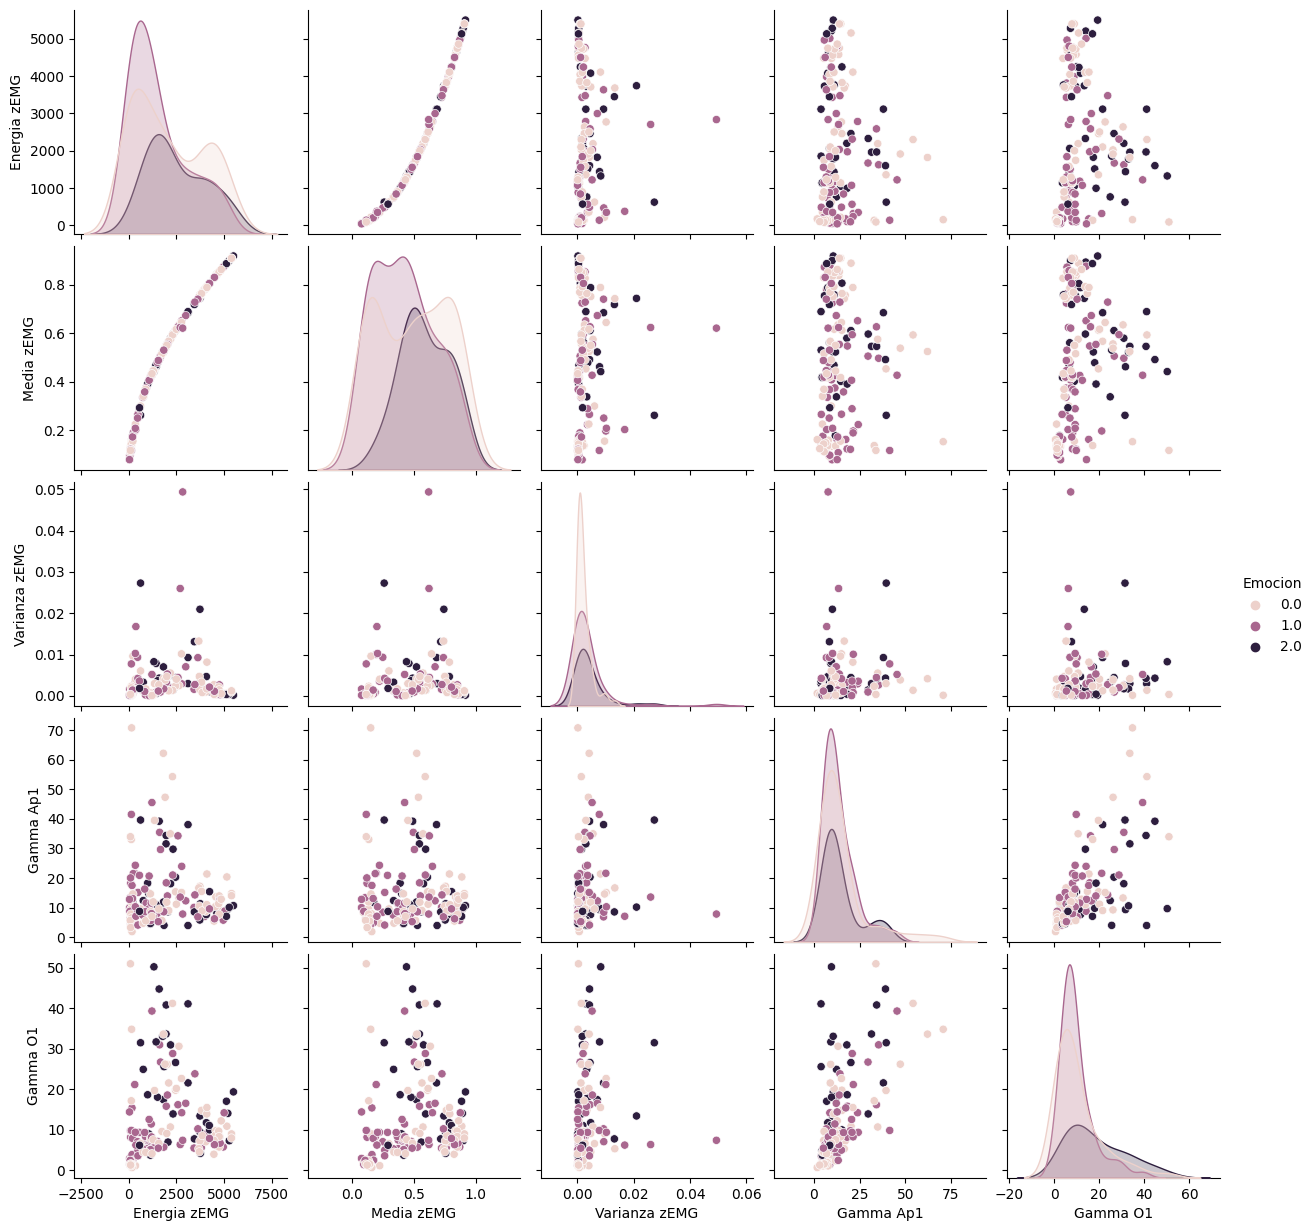

In [ ]:
#newDATA1['Emocion'] = newDATA1['Emocion'].astype('category')

sns.pairplot(newDATA1, hue= 'Emocion')

##CONCLUSIONES

-